In [1]:
#%%
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.getcwd()

'/Users/mgorecki/Documents/projects/llm_fairness/folktexts'

In [3]:
import torch
import numpy
import os
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import json
from pathlib import Path
import matplotlib as mpl
import pandas as pd

import folktexts
from folktexts.llm_utils import get_model_size_B
#load the dataset
from folktexts.acs.acs_tasks import ACSTaskMetadata
from folktexts.acs.acs_dataset import ACSDataset

#baselines
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from folktexts.evaluation import evaluate_predictions
from folktexts._io import load_json, save_json

plot_config_file = "./results/.matplotlibrc"
plt.rcParams.update(mpl.rc_params_from_file(fname=plot_config_file))

data_dir = Path("./data")

In [4]:
# LLMs to evaluate
LLM_MODELS = [
    # Google Gemma2 models
    "google/gemma-2b",
    "google/gemma-1.1-2b-it",
    "google/gemma-7b",
    "google/gemma-1.1-7b-it",
    "google/gemma-2-9b",
    "google/gemma-2-9b-it",
    "google/gemma-2-27b",
    "google/gemma-2-27b-it",
    # Meta Llama3 models
    "meta-llama/Meta-Llama-3-8B",
    "meta-llama/Meta-Llama-3-8B-Instruct",
    "meta-llama/Meta-Llama-3-70B",
    "meta-llama/Meta-Llama-3-70B-Instruct",
    # Mistral AI models
    "mistralai/Mistral-7B-v0.1",
    "mistralai/Mistral-7B-Instruct-v0.2",
    "mistralai/Mixtral-8x7B-v0.1",
    "mistralai/Mixtral-8x7B-Instruct-v0.1",
    "mistralai/Mixtral-8x22B-v0.1",
    "mistralai/Mixtral-8x22B-Instruct-v0.1",
    # Yi models
    "01-ai/Yi-34B",
    "01-ai/Yi-34B-Chat",
    # Qwen2 models
    # "Qwen/Qwen2-1.5B",
    # "Qwen/Qwen2-1.5B-Instruct",
    # "Qwen/Qwen2-7B",
    # "Qwen/Qwen2-7B-Instruct",
    # "Qwen/Qwen2-72B",
    # "Qwen/Qwen2-72B-Instruct",
]

In [5]:
numpy.random.randint(low=0,high=999, size=3)

array([261, 866, 808])

## ACS Tasks

In [6]:
# All ACS prediction tasks
ACS_TASKS = (
    "ACSIncome",
    "ACSEmployment",
    "ACSMobility",
    "ACSTravelTime",
    "ACSPublicCoverage",
)

In [7]:
# Load test data

# Fetch ACS task and dataset
task_name = ACS_TASKS[0]
acs_task = ACSTaskMetadata.get_task(task_name)
acs_dataset_configs = folktexts.benchmark.Benchmark.ACS_DATASET_CONFIGS.copy()
# acs_dataset = ACSDataset.make_from_task(
#     task=acs_task, cache_dir=data_dir, **acs_dataset_configs
# )
# X_test, y_test = acs_dataset.get_data_split("test")

In [8]:
descriptions_cols = {
    col: acs_task.cols_to_text[col].short_description for col in acs_task.features
}
descriptions_cols

{'AGEP': 'age',
 'COW': 'class of worker',
 'SCHL': 'highest educational attainment',
 'MAR': 'marital status',
 'OCCP': 'occupation',
 'POBP': 'place of birth',
 'RELP': 'relationship to the reference person in the survey',
 'WKHP': 'usual number of hours worked per week',
 'SEX': 'sex',
 'RAC1P': 'race'}

## Load LLM Predictions and Evaluation Results

In [9]:
# RESULTS_ROOT_DIR = Path("./results/vary-seeds/")
RESULTS_ROOT_DIR = Path("./results/eval-fairness/")

In [10]:
## Utility functions for data loading


def load_json(path: str | Path) -> object:
    """Loads a JSON file from disk and returns the deserialized object."""
    with open(path, "r") as f_in:
        return json.load(f_in)


def find_files(root_folder, pattern, dir_pattern=""):
    # Compile the regular expression pattern
    regex = re.compile(pattern)

    # Walk through the directory tree
    for dirpath, dirnames, filenames in os.walk(root_folder):
        if dir_pattern in dirpath:
            for filename in filenames:
                if regex.match(filename):
                    # If the filename matches the pattern, add it to the list
                    yield os.path.join(dirpath, filename)


def parse_model_name(name: str) -> str:
    name = name[name.find("--") + 2 :]
    return name


def get_base_name(name):
    name = name.replace("-Instruct", "")
    name = name.replace("-Chat", "")
    name = name.replace("-it", "")
    name = name.replace("-1.1", "")
    name = name.replace("-v0.2", "-v0.1")
    return name


model_col = "config_model_name"
# model_col = "model_name"
feature_subset_col = "config_feature_subset"
population_subset_col = "config_population_filter"
predictions_path_col = "predictions_path"

uses_all_features_col = "uses_all_features"
uses_all_samples_col = "uses_all_samples"


def parse_results_dict(dct) -> dict:
    """Parses results dict; brings all information to the top-level."""
    dct = dct.copy()
    dct.pop("plots", None)
    config = dct.pop("config", {})
    for key, val in config.items():
        dct[f"config_{key}"] = val

    # Parse model name
    dct[model_col] = parse_model_name(dct[model_col])
    dct[uses_all_features_col] = dct[feature_subset_col] is None
    if dct[feature_subset_col] is None:
        dct[feature_subset_col] = "full"

    dct[uses_all_samples_col] = dct[population_subset_col] is None

    dct["base_name"] = get_base_name(dct[model_col])
    dct["is_inst"] = dct["base_name"] != dct[model_col]

    assert not any(isinstance(val, dict) for val in dct.values()), dct
    return dct

In [11]:
risk_scores_all_tasks = {}  # [task] -> pd dataframe with[identifier]_bench-[bench] as column name
results_all_tasks = {}  # [task][identifier][bench]
for task_name in ACS_TASKS:
    # Results file name pattern
    pattern_json = r"^results.bench-(?P<hash>\d+)[.]json$" 
    # Find results files
    results = {}
    risk_scores = []
    for file_path in find_files(RESULTS_ROOT_DIR, pattern_json, dir_pattern=task_name):
        identifier = (
            Path(file_path)
            .parent.parent.name.replace(f".dataset-{task_name}", "")
            .replace("model-", "")
        )
        bench_id = Path(file_path).parent.name.split("_bench-")[1]
        print(identifier, bench_id)

        if identifier in results.keys(): ## avoid overwriting if there are multiple benches!
            results[identifier][bench_id] = parse_results_dict(load_json(file_path))
        else:
            results[identifier] = {bench_id : parse_results_dict(load_json(file_path))} 
        
        csv_path = results[identifier][bench_id]["predictions_path"].split('folktexts/')[1]
        risk_scores.append(
            pd.read_csv(csv_path, index_col=0)
            .drop("label", axis=1)
            .rename(columns={"risk_score": identifier+'_bench-'+bench_id})
        )

    results_all_tasks[task_name] = results
    # aggregate pd series
    risk_scores = pd.concat(risk_scores, axis=1)
    risk_scores_all_tasks[task_name] = risk_scores

google--gemma-2b_task-ACSIncome 1642543374
google--gemma-2-27b-it_task-ACSIncome 1114116852
mistralai--Mixtral-8x7B-Instruct-v0.1_task-ACSIncome 1236026685
google--gemma-2-9b_task-ACSIncome 1498646399
google--gemma-2-27b_task-ACSIncome 598169298
mistralai--Mixtral-8x22B-v0.1_task-ACSIncome 3233282695
01-ai--Yi-34B_task-ACSIncome 1904105971
google--gemma-1.1-7b-it_task-ACSIncome 598015031
01-ai--Yi-34B-Chat_task-ACSIncome 2653191334
mistralai--Mistral-7B-v0.1_task-ACSIncome 2194721237
meta-llama--Meta-Llama-3-8B-Instruct_task-ACSIncome 2649963821
mistralai--Mixtral-8x22B-Instruct-v0.1_task-ACSIncome 2740956079
mistralai--Mistral-7B-Instruct-v0.2_task-ACSIncome 2333630847
meta-llama--Meta-Llama-3-70B_task-ACSIncome 3309047833
google--gemma-1.1-2b-it_task-ACSIncome 3399693290
google--gemma-2-9b-it_task-ACSIncome 334175777
meta-llama--Meta-Llama-3-8B_task-ACSIncome 1849078350
meta-llama--Meta-Llama-3-70B-Instruct_task-ACSIncome 357440873
mistralai--Mixtral-8x7B-v0.1_task-ACSIncome 10348017

## Baseline Models

In [12]:
baselines = {
    "Constant": DummyClassifier(strategy='prior'),
    "LR": LogisticRegression(),
    "GBM": HistGradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
}

In [13]:
def fit_and_eval(
    clf: LogisticRegression | HistGradientBoostingClassifier | XGBClassifier | DummyClassifier,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_test: torch.Tensor,
    y_test: torch.Tensor,
    s_test: torch.Tensor,
    fillna: bool = False,
) -> dict:
    """Fit and evaluate a given classifier on the given data."""
    assert len(X_train) == len(y_train) and len(X_test) == len(y_test) == len(s_test)

    train_nan_count = X_train.isna().any(axis=1).sum()
    if fillna and train_nan_count > 0:
        print(f"Found {train_nan_count} NaN values, fill with -1.")
        # Fill NaNs with value=-1
        X_train = X_train.fillna(axis="columns", value=-1)
        X_test = X_test.fillna(axis="columns", value=-1)

    # Fit on train data
    clf.fit(X_train, y_train)

    # Evaluate on test data
    y_test_scores = clf.predict_proba(X_test)[:, -1]
    clf_prediction_eval = evaluate_predictions(
        y_true=y_test.to_numpy(),
        y_pred_scores=y_test_scores,
        sensitive_attribute=s_test,
        threshold=0.5,
    )

    return y_test_scores, clf_prediction_eval

def add_meta_data(results: dict, task: str, clf_name: str):
    updated_results = results.copy()
    updated_results["config_task_name"] = task
    updated_results["config_model_name"] = clf_name
    updated_results["name"] = clf_name
    updated_results["num_features"] = -1
    updated_results["uses_all_features"] = True
    
    return updated_results

In [14]:
BASELINE_RESULTS_PATH =  RESULTS_ROOT_DIR / 'baseline-results/'

In [ ]:
def run_baselines(tasks: list, rerun: bool=False):
    baseline_results_all_tasks = {}
    baseline_risk_scores_all_tasks = {}
    for task_name in tasks:
        print(task_name)
        dataset = ACSDataset.make_from_task(
            task_name, cache_dir=data_dir, **acs_dataset_configs
        )

        X_train, y_train = dataset.get_train()
        X_test, y_test = dataset.get_test()
        s_test = None
        if dataset.task.sensitive_attribute is not None:
            s_test = dataset.get_sensitive_attribute_data().loc[y_test.index]

        print("Run baselines")
        results = {}
        risk_scores = []
        for clf_name, clf in baselines.items():
            clf_path = BASELINE_RESULTS_PATH / f"{clf_name}_task-{task_name}"
            if (clf_path).exists() and not rerun:
                print("Load predictions from file.")
                scores = pd.read_csv(clf_path / f'{task_name}.test_predictions.csv')
                prediction_eval = load_json(path=clf_path / f'{task_name}-results.bench.json')
            else: 
                scores, prediction_eval = fit_and_eval(
                    clf, X_train, y_train, X_test, y_test, s_test, fillna=(clf_name == "LR")
                )
                scores = pd.Series(scores, index=y_test.index, name=f"{clf_name}_task-{task_name}")
                prediction_eval = add_meta_data(prediction_eval, task=task_name, clf_name=clf_name)

                print(f"Save predictions at '{clf_path}'.")
                clf_path.mkdir(parents=True, exist_ok=True)
                scores.to_csv( clf_path / f'{task_name}.test_predictions.csv')
                save_json(obj=prediction_eval, path=clf_path / f'{task_name}-results.bench.json')
                
            results[clf_name] = prediction_eval
            risk_scores.append(scores)

        baseline_results_all_tasks[task_name] = results
        baseline_risk_scores_all_tasks[task_name] = pd.concat(risk_scores, axis=1)

    return baseline_risk_scores_all_tasks, baseline_results_all_tasks

In [16]:
baseline_results = run_baselines(tasks=ACS_TASKS)

ACSIncome
Loading ACS data...
Run baselines
Load predictions from file.
Load predictions from file.
Load predictions from file.
Load predictions from file.
ACSEmployment
Loading ACS data...
Run baselines
Load predictions from file.
Load predictions from file.
Load predictions from file.
Load predictions from file.
ACSMobility
Loading ACS data...
Run baselines
Load predictions from file.
Load predictions from file.
Load predictions from file.
Load predictions from file.
ACSTravelTime
Loading ACS data...
Run baselines
Load predictions from file.
Load predictions from file.
Load predictions from file.
Load predictions from file.
ACSPublicCoverage
Loading ACS data...
Run baselines
Load predictions from file.
Load predictions from file.
Load predictions from file.
Load predictions from file.


In [17]:
baseline_risk_scores_all_tasks, baseline_results_all_tasks = baseline_results

## Evaluate Results

In [18]:
model_colors = {
    "gemma": "tab:blue",
    "Meta": "tab:olive",
    "Mistral": "tab:orange",
    "Yi": "tab:green",
    "Mixtral": "tab:red",
}

def prettify_model_name(name: str) -> str:
    """Get prettified version of the given model name."""
    dct = {
        "meta-llama/Meta-Llama-3-70B": "Llama 3 70B",
        "meta-llama/Meta-Llama-3-70B-Instruct": "Llama 3 70B (it)",
        "meta-llama/Meta-Llama-3-8B": "Llama 3 8B",
        "meta-llama/Meta-Llama-3-8B-Instruct": "Llama 3 8B (it)",
        "mistralai/Mistral-7B-Instruct-v0.2": "Mistral 7B (it)",
        "mistralai/Mistral-7B-v0.1": "Mistral 7B",
        "mistralai/Mixtral-8x22B-Instruct-v0.1": "Mixtral 8x22B (it)",
        "mistralai/Mixtral-8x22B-v0.1": "Mixtral 8x22B",
        "mistralai/Mixtral-8x7B-Instruct-v0.1": "Mixtral 8x7B (it)",
        "mistralai/Mixtral-8x7B-v0.1": "Mixtral 8x7B",
        "01-ai/Yi-34B": "Yi 34B",
        "01-ai/Yi-34B-Chat": "Yi 34B (chat)",
        "google/gemma-1.1-2b-it": "Gemma 2B (it)",
        "google/gemma-1.1-7b-it": "Gemma 7B (it)",
        "google/gemma-2b": "Gemma 2B",
        "google/gemma-7b": "Gemma 7B",
        "google/gemma-2-9b": "Gemma 2 9B",
        "google/gemma-2-9b-it": "Gemma 2 9B (it)",
        "google/gemma-2-27b": "Gemma 2 27B",
        "google/gemma-2-27b-it": "Gemma 2 27B (it)",
    }

    if name in dct:
        return dct[name]
    else:
        print(f"Couldn't find prettified name for {name}.")
        return name

Check for incomplete results

In [19]:
for t in ACS_TASKS:
    model_missing = False
    to_print = f"{t}\n"
    for m in LLM_MODELS:
        if m.replace("/", "--") + f"_task-{t}" not in list(results_all_tasks[t].keys()):
            to_print += f"- {m}\n"
            model_missing = True
    if model_missing:
        print(to_print)

ACSTravelTime
- meta-llama/Meta-Llama-3-70B-Instruct



In [20]:
finished_models = [
    m
    for m in LLM_MODELS
    if m.replace("/", "--") + f"_task-{task_name}"
    in list(results_all_tasks[task_name].keys())
]
finished_models.sort(key=get_model_size_B)
finished_models

['google/gemma-2b',
 'google/gemma-1.1-2b-it',
 'google/gemma-7b',
 'google/gemma-1.1-7b-it',
 'mistralai/Mistral-7B-v0.1',
 'mistralai/Mistral-7B-Instruct-v0.2',
 'meta-llama/Meta-Llama-3-8B',
 'meta-llama/Meta-Llama-3-8B-Instruct',
 'google/gemma-2-9b',
 'google/gemma-2-9b-it',
 'google/gemma-2-27b',
 'google/gemma-2-27b-it',
 '01-ai/Yi-34B',
 '01-ai/Yi-34B-Chat',
 'mistralai/Mixtral-8x7B-v0.1',
 'mistralai/Mixtral-8x7B-Instruct-v0.1',
 'meta-llama/Meta-Llama-3-70B',
 'meta-llama/Meta-Llama-3-70B-Instruct',
 'mistralai/Mixtral-8x22B-v0.1',
 'mistralai/Mixtral-8x22B-Instruct-v0.1']

In [21]:
# utils 

model_name_only = lambda m: m.split("/")[1] if "/" in m else m
model_to_key = lambda m, t: m.replace("/", "--") + f"_task-{t}"


def get_models_for_task(task: str) -> list:
    """Get a list of models for which results are available. 

    Args:
        task (str): task name, one of ACS_TASKS

    Returns:
        list: list of model names
    """
    models = [
        m
        for m in LLM_MODELS
        if m.replace("/", "--") + f"_task-{task}"
        in list(results_all_tasks[task].keys())
    ]
    models.sort(key=get_model_size_B)
    return models


def is_instruction_tuned(model_name: str) -> bool:
    """ Indicator if a model is instruction tuned (solely inferred from the model name).

    Args:
        model_name (str): name of the model

    Returns:
        bool: model is instruction-finetuned
    """
    indicators = ["Instruct", "it", "Chat"]
    return any(ind in model_name for ind in indicators)

In [22]:
colors = cm.rainbow(numpy.linspace(0, 1, len(baselines.keys())+1))[1:]
baseline_colors = {list(baselines.keys())[i]: colors[i] for i in range(len(baselines.keys()))}


In [26]:
def scatter_plot(task, metric, upper_lim=1.01):
    models = get_models_for_task(task)
    models_non_instruct = [m for m in models if not is_instruction_tuned(m)]
    models_instruct = [m for m in models if is_instruction_tuned(m)]

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(task, fontsize=14)

    axs[0].set_title("Non-Instruction-Tuned")
    axs[0].set_xlabel("models")
    axs[0].set_ylim(0, upper_lim)
    axs[0].set_ylabel(metric)
    axs[0].set_xticks(
        torch.arange(0, len(models_non_instruct)),
        list(map(prettify_model_name, models_non_instruct)),
        rotation=45,
        ha="right",
    )

    axs[1].set_title("Instruction-Tuned")
    axs[1].set_xlabel("models")
    axs[1].set_ylim(0, upper_lim)
    axs[1].set_ylabel(metric)
    axs[1].set_xticks(
        torch.arange(0, len(models_instruct)),
        list(map(prettify_model_name, models_instruct)),
        rotation=45,
        ha="right",
    )

    offset = 0.4
    for i, modelset in enumerate([models_non_instruct, models_instruct]):
        for baseline_name, baseline_res in baseline_results_all_tasks[task].items(): 
            if baseline_name in ["Constant", "GBM"]:
                axs[i].hlines(baseline_res[metric], xmin=-offset, xmax=len(modelset)-(1-offset), colors=baseline_colors[baseline_name], label=baseline_name, linestyle='-', zorder=0)

    
    for m in models:
        idx = (
            models_non_instruct.index(m)
            if not is_instruction_tuned(m)
            else models_instruct.index(m)
        )

        results_model = results_all_tasks[task][model_to_key(m, task)]
        if len(results_model.keys())>1:
            print(f"Multiple benchmark runs available, using first: {results_model.keys()[0]}")
        results_model = results_model[list(results_model.keys())[0]]

        axs[int(is_instruction_tuned(m))].scatter(
            idx,
            results_model[metric],
            c=model_colors[m.split("/")[1].split("-")[0]],
            s=20,
        )

    legend_items = axs[0].get_legend_handles_labels()
    handles = legend_items[0]#+ legend_costs[0]
    labels = legend_items[1] #+ legend_costs[1]

    plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.0, 1.0), handlelength=0.95, handletextpad=0.5)
    plt.show()


def bar_plot(task, metric, bar_width=0.25):
    models = get_models_for_task(task)
    models_non_instruct = [m for m in models if not is_instruction_tuned(m)]
    models_instruct = [m for m in models if is_instruction_tuned(m)]

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(task, fontsize=14)

    axs[0].set_title("Non-Instruction-Tuned")
    axs[0].set_xlabel("models")
    axs[0].set_ylim(0, 1.01)
    axs[0].set_ylabel(metric)
    axs[0].set_xticks(
        torch.arange(0, len(models_non_instruct)),
        list(map(model_name_only, models_non_instruct)),
        rotation=45,
        ha="right",
    )

    axs[1].set_title("Instruction-Tuned")
    axs[1].set_xlabel("models")
    axs[1].set_ylim(0, 1.01)
    axs[1].set_ylabel(metric)
    axs[1].set_xticks(
        torch.arange(0, len(models_instruct)),
        list(map(model_name_only, models_instruct)),
        rotation=45,
        ha="right",
    )

    offset = 0.4
    for i, modelset in enumerate([models_non_instruct, models_instruct]):
        for baseline_name, baseline_res in baseline_results_all_tasks[task].items(): 
            axs[i].hlines(baseline_res[metric], xmin=-offset, xmax=len(modelset)-(1-offset), colors=baseline_colors[baseline_name], label=baseline_name)


    for m in models:
        idx = (
            models_non_instruct.index(m)
            if not is_instruction_tuned(m)
            else models_instruct.index(m)
        )
        axs[int(is_instruction_tuned(m))].bar(
            idx,
            results_all_tasks[task][model_to_key(m, task)][metric],
            width=bar_width,
            color=model_colors[m.split("/")[1].split("-")[0]],
        )

    plt.show()

In [27]:
# list tasks, features and target 
for task_name in ACS_TASKS:
    print("\n", task_name)
    acs_task = ACSTaskMetadata.get_task(task_name)
    descriptions_cols = {
        col: acs_task.cols_to_text[col].short_description for col in acs_task.features
    }
    print("Features", acs_task.features)
    print(descriptions_cols)
    print("Sensitive Attribute", acs_task.sensitive_attribute)
    print("Target", acs_task.get_target())


 ACSIncome
Features ['AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'WKHP', 'SEX', 'RAC1P']
{'AGEP': 'age', 'COW': 'class of worker', 'SCHL': 'highest educational attainment', 'MAR': 'marital status', 'OCCP': 'occupation', 'POBP': 'place of birth', 'RELP': 'relationship to the reference person in the survey', 'WKHP': 'usual number of hours worked per week', 'SEX': 'sex', 'RAC1P': 'race'}
Sensitive Attribute RAC1P
Target PINCP>50000

 ACSEmployment
Features ['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P']
{'AGEP': 'age', 'SCHL': 'highest educational attainment', 'MAR': 'marital status', 'RELP': 'relationship to the reference person in the survey', 'DIS': 'disability status', 'ESP': 'employment status of parents', 'CIT': 'citizenship status', 'MIG': 'mobility status over the last year', 'MIL': 'military service status', 'ANC': 'ancestry', 'NATIVITY': 'nativity', 'DEAR': 'hearing status', 'DEYE': 'vision 

## Non-Instruction-Tuned Models vs. Instruction-Tuned Mondels

### Overall Accuracy

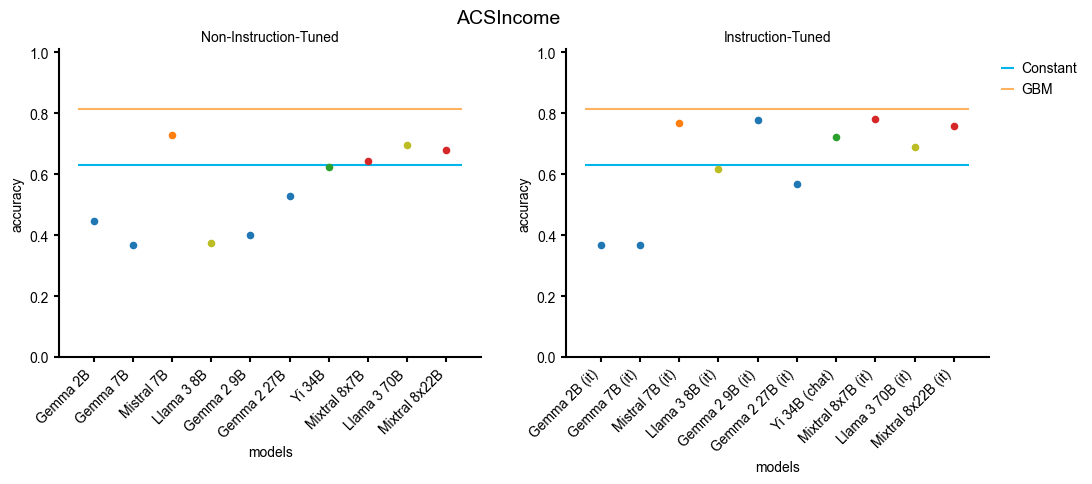

Constant : 0.6321
LR : 0.7429
GBM : 0.8132
XGBoost : 0.8173


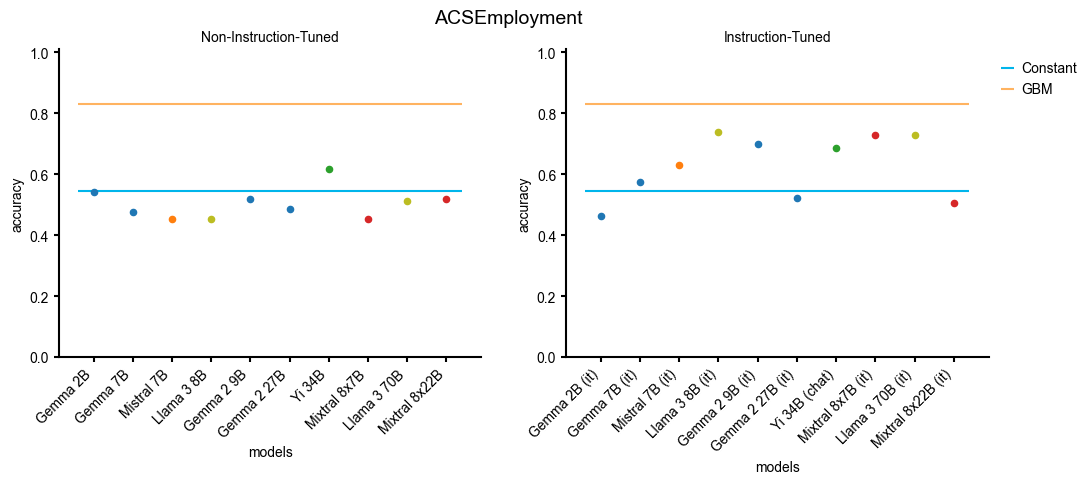

Constant : 0.5466
LR : 0.7835
GBM : 0.8311
XGBoost : 0.8316


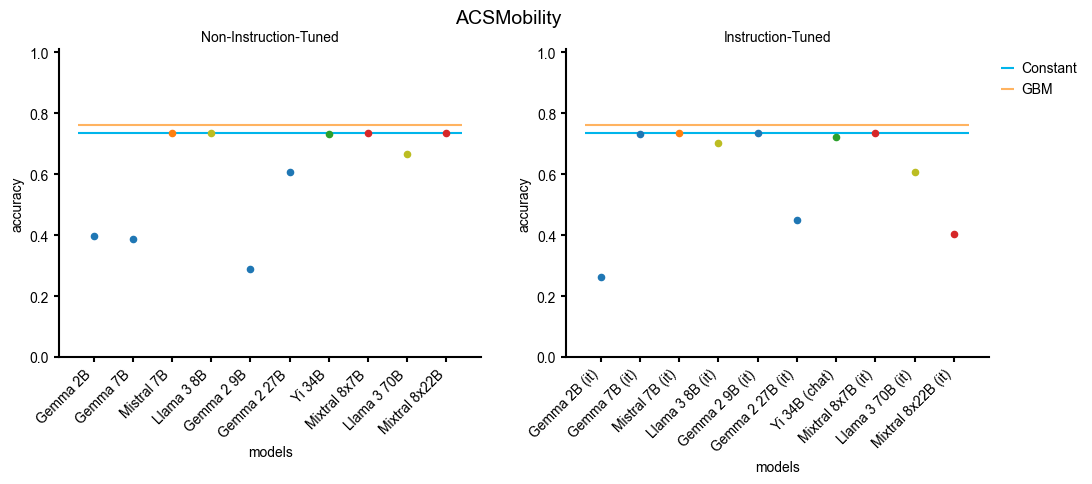

Constant : 0.7351
LR : 0.7356
GBM : 0.7630
XGBoost : 0.7643


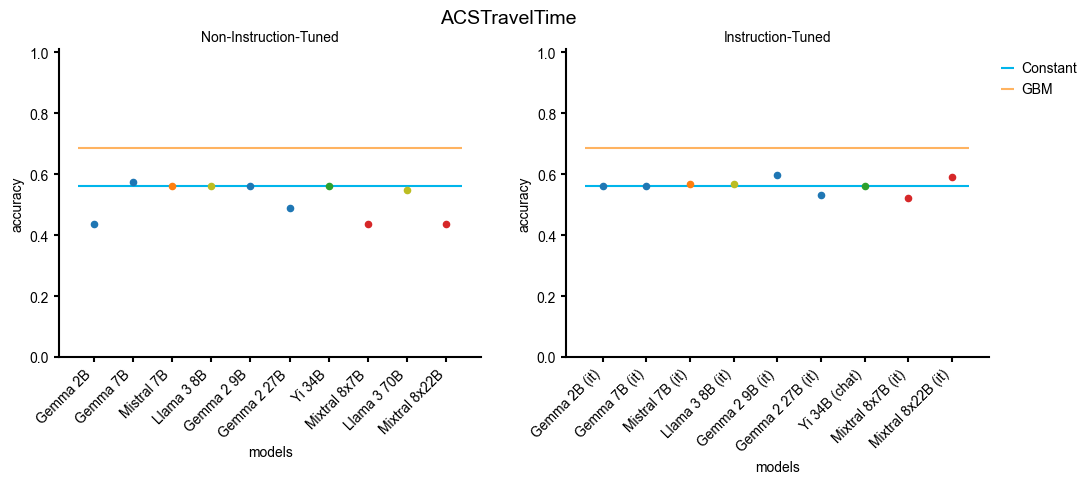

Constant : 0.5617
LR : 0.5563
GBM : 0.6874
XGBoost : 0.7030


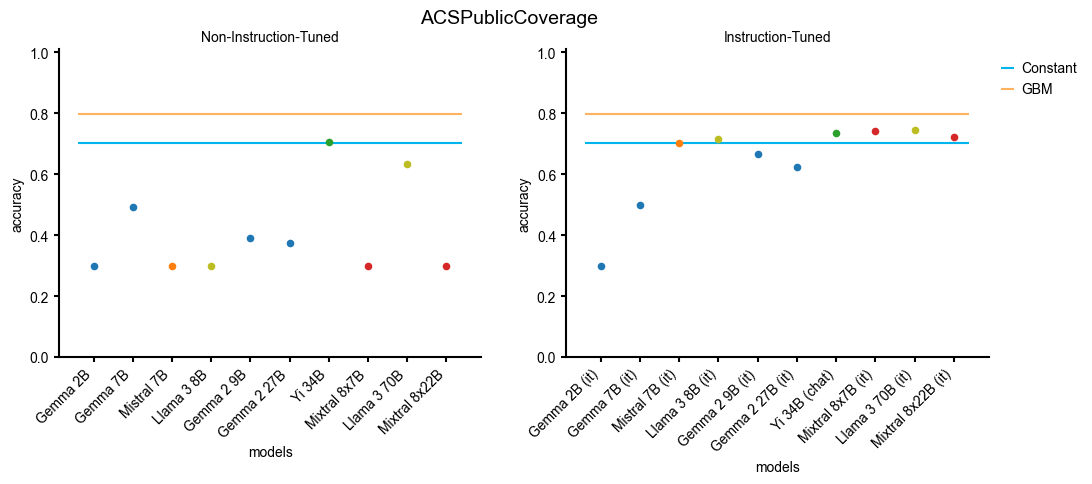

Constant : 0.7016
LR : 0.7263
GBM : 0.7981
XGBoost : 0.8016


In [29]:
metric = 'accuracy'
for task in ACS_TASKS:
    scatter_plot(task, metric= metric)
    for baseline_name, baseline_res in baseline_results_all_tasks[task].items(): 
        print(f"{baseline_name} : {baseline_res[metric]:.4f}")

### Fairness Violations

#### FNR

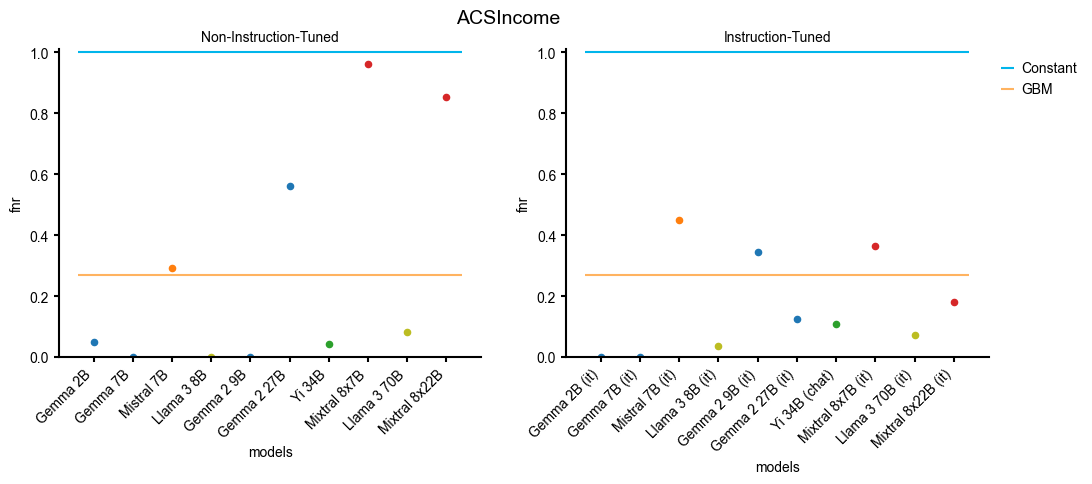

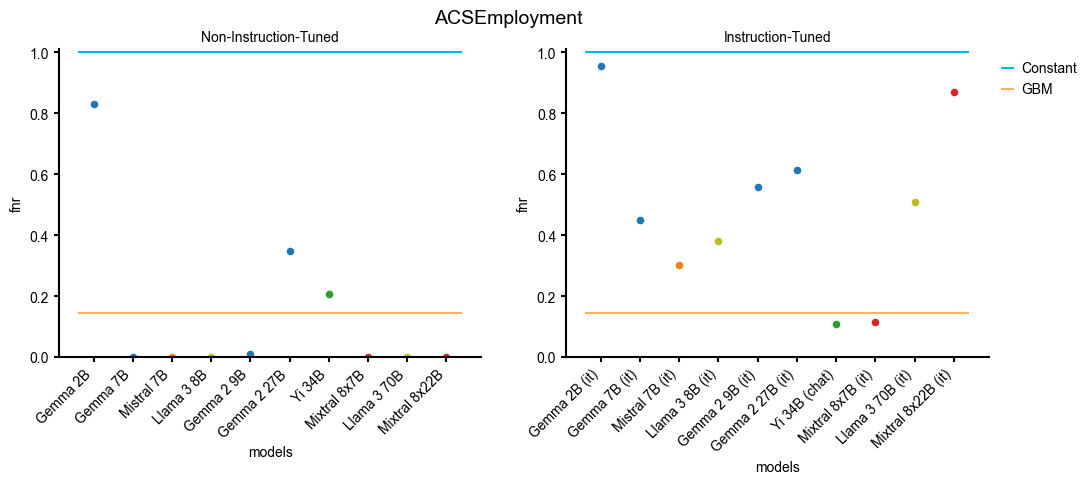

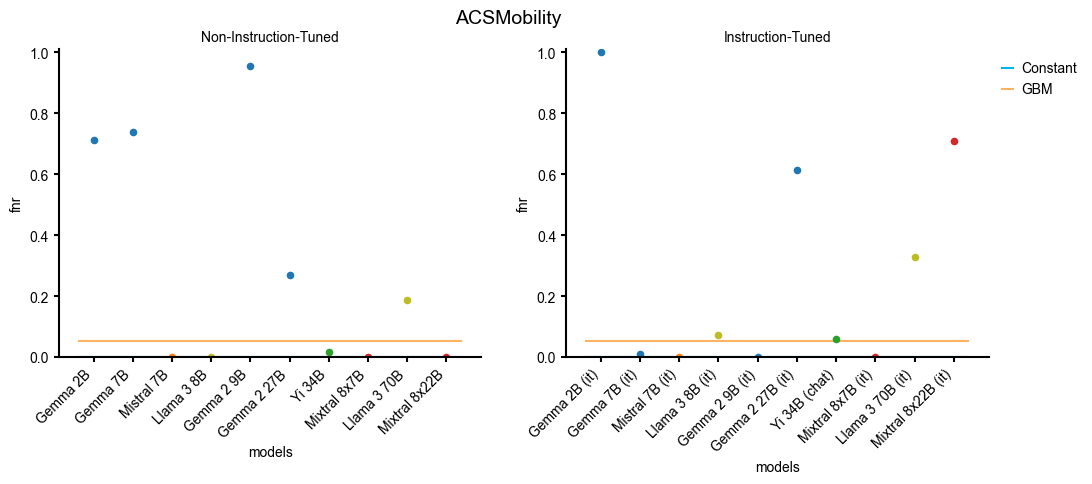

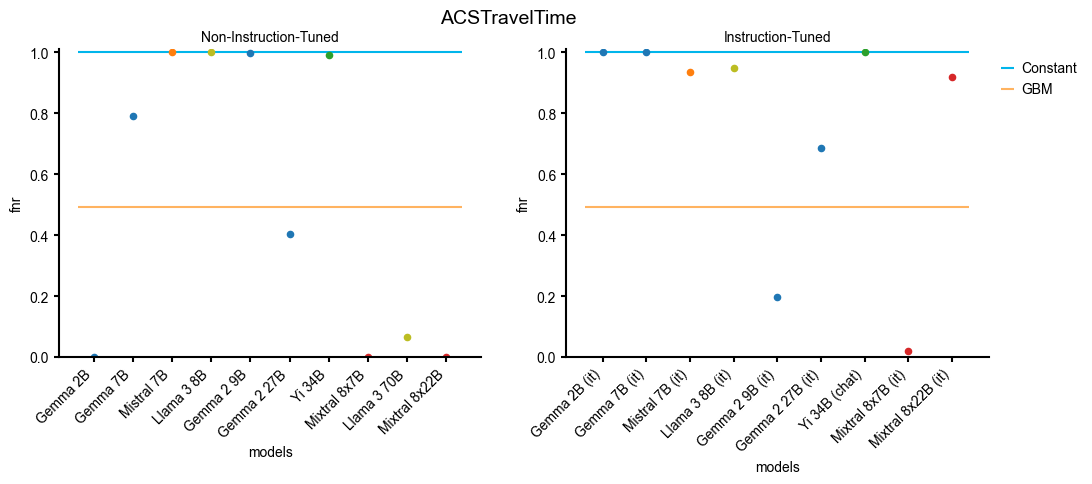

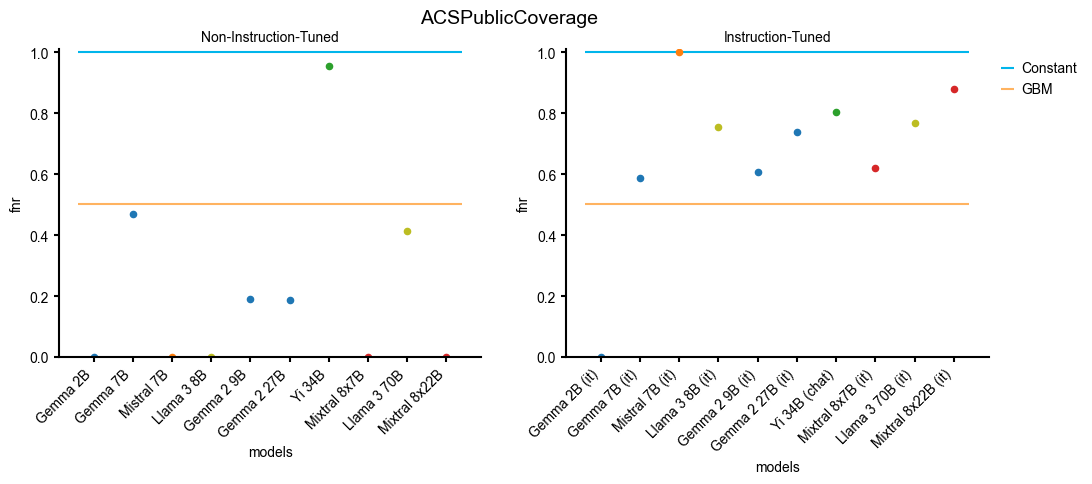

In [30]:
for task in ACS_TASKS:
    scatter_plot(task, metric="fnr")  # 1-tpr

#### Max difference in FNR

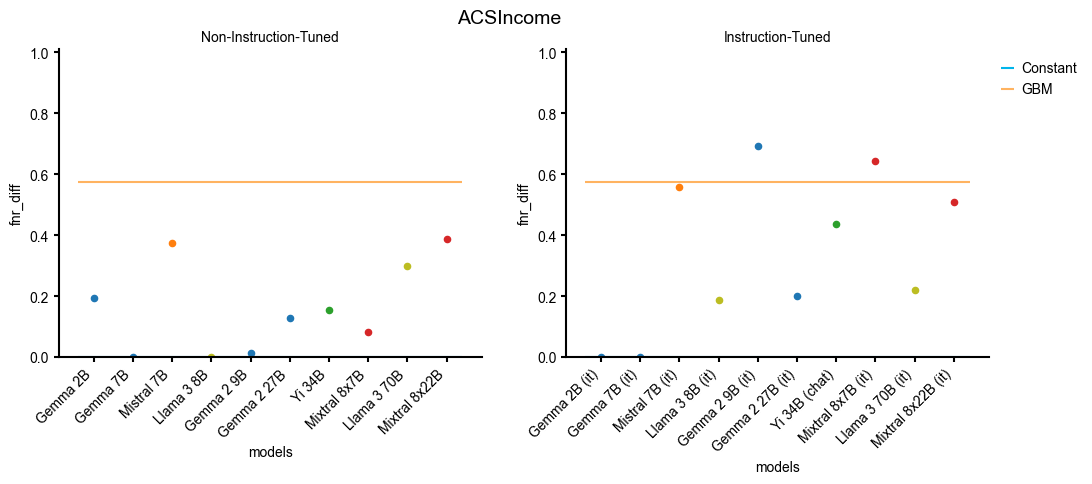

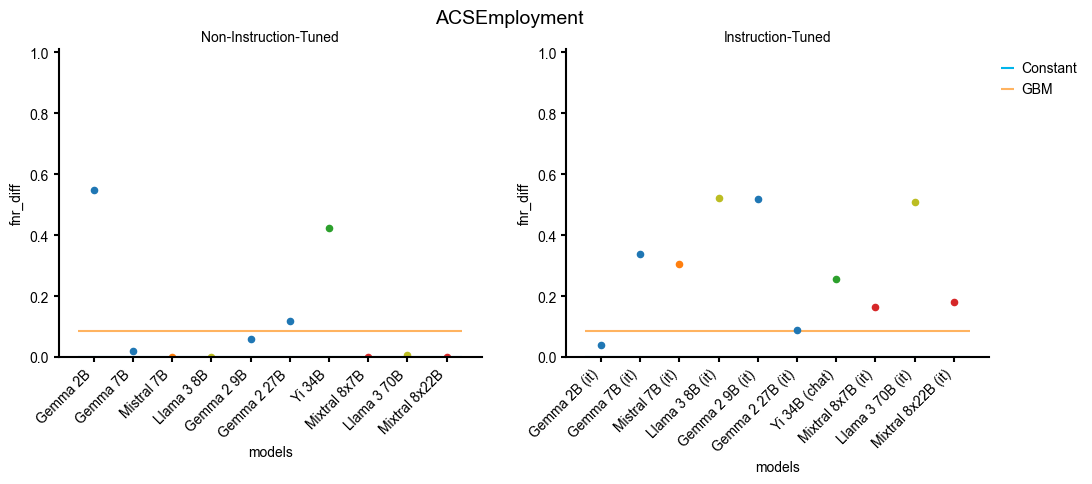

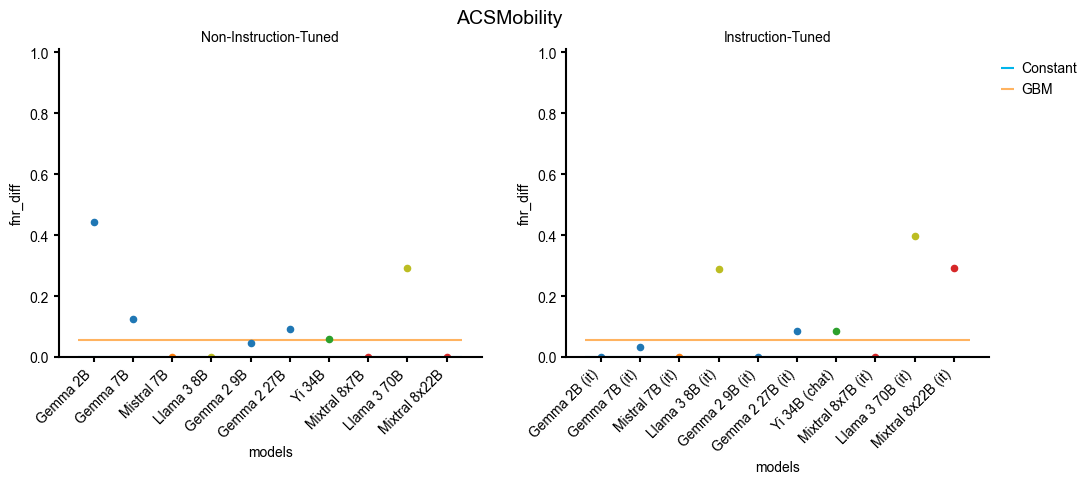

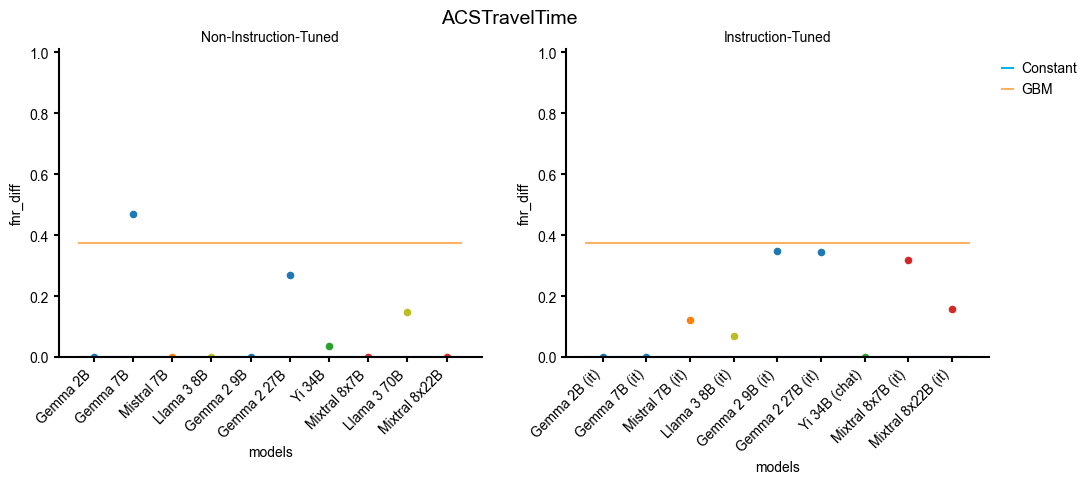

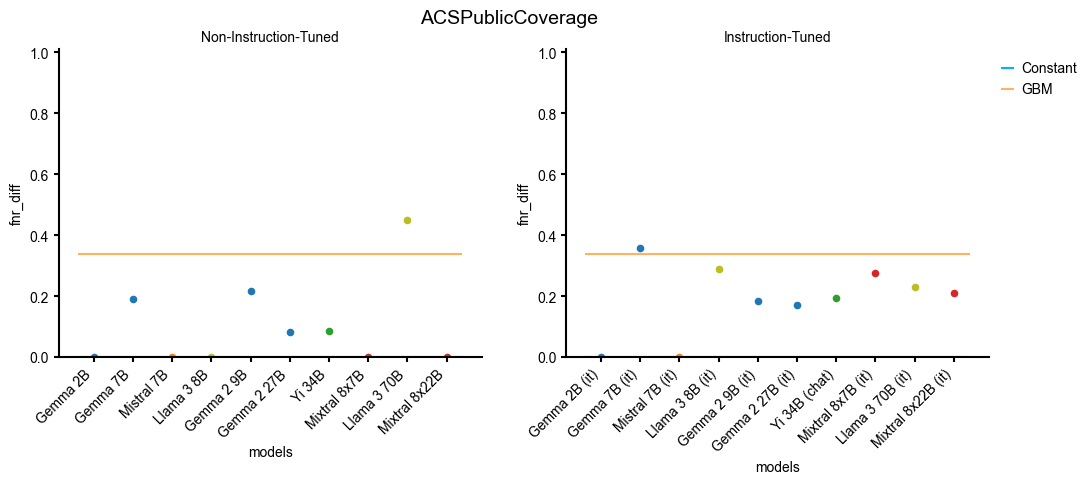

In [31]:
for task in ACS_TASKS:
    scatter_plot(task, metric="fnr_diff")  # 1-tpr

#### FPR

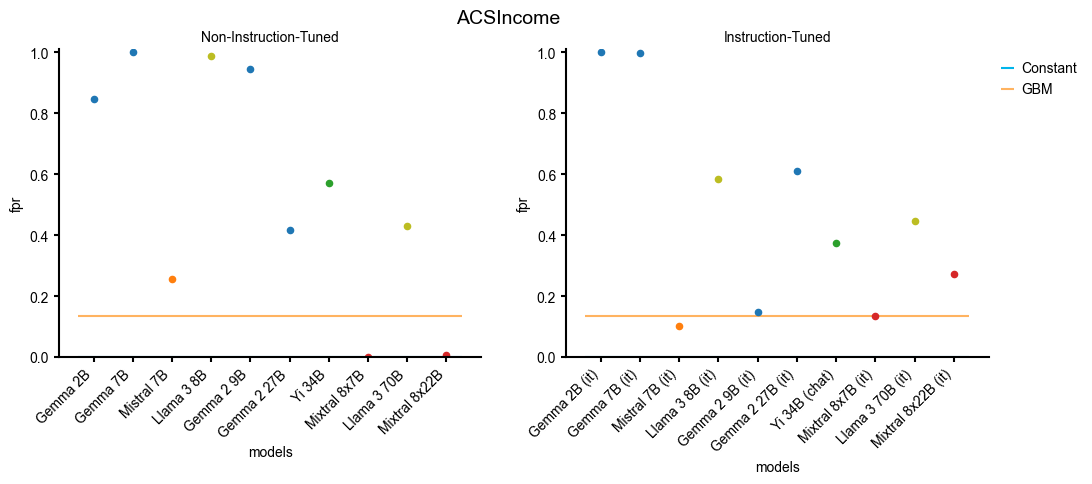

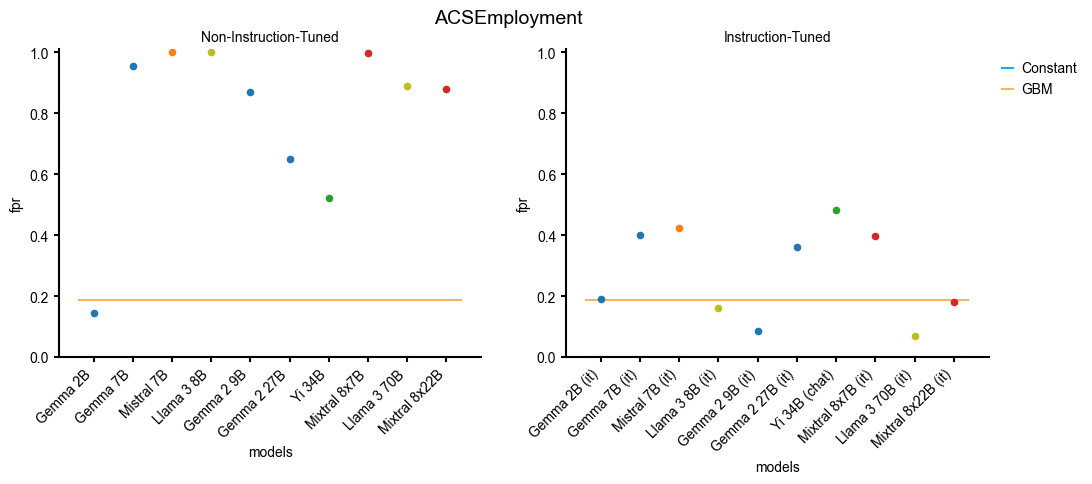

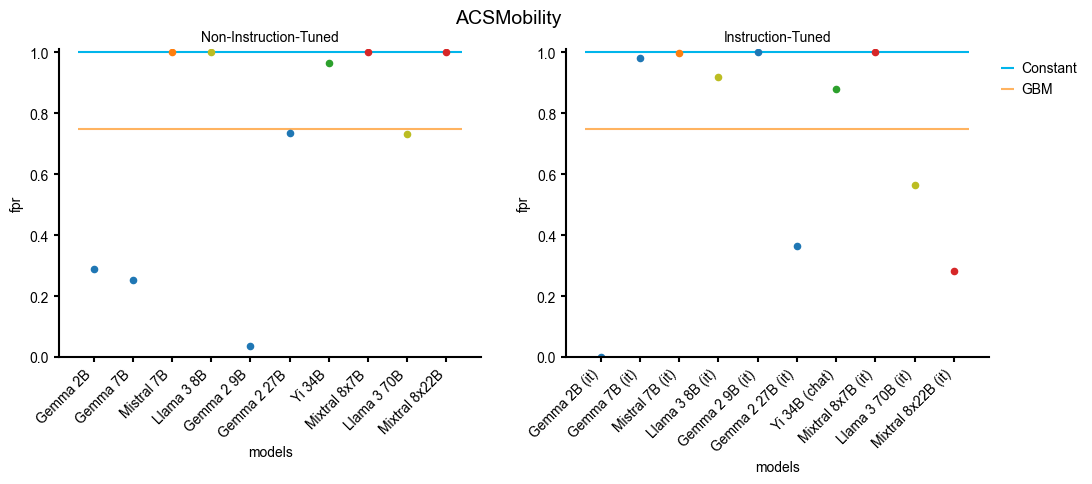

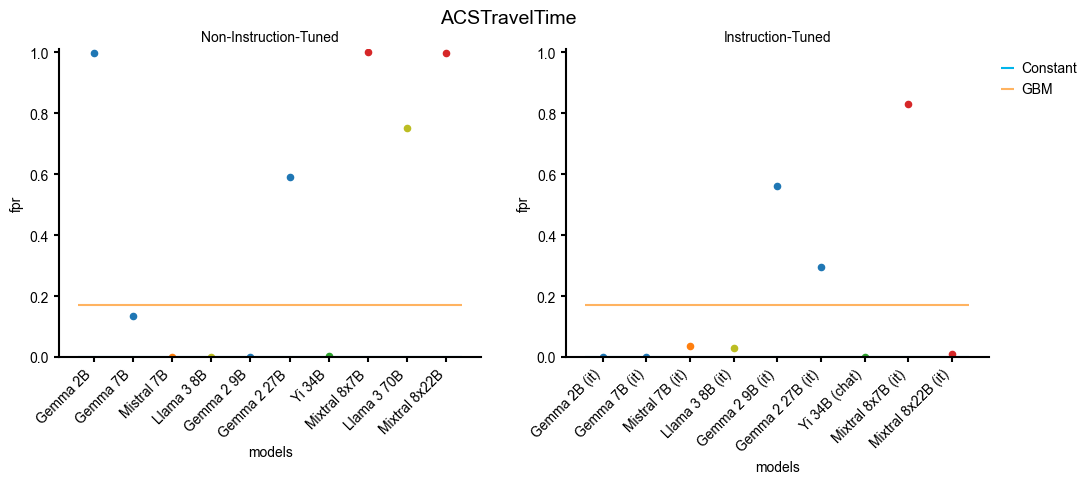

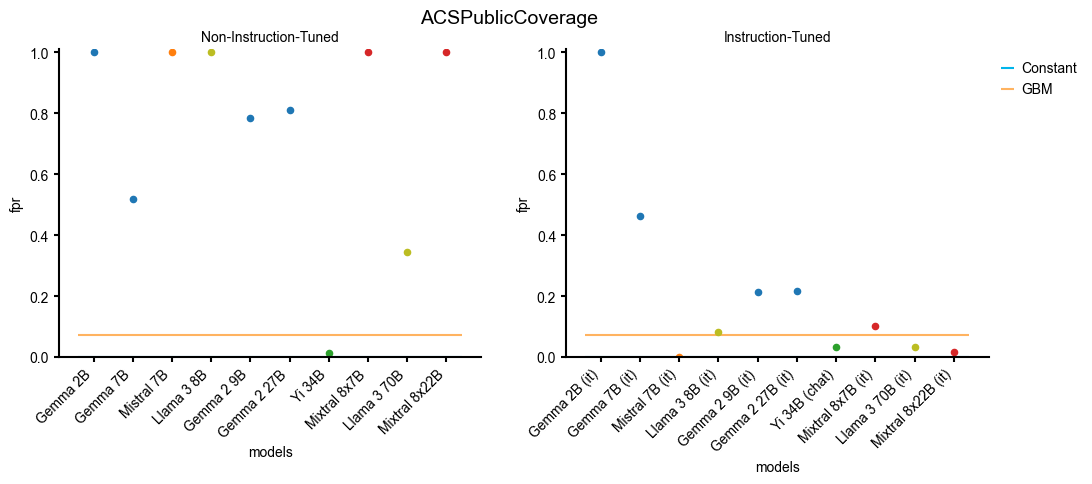

In [32]:
for task in ACS_TASKS:
    scatter_plot(task, metric="fpr")  # 1-tnr

#### Max difference in FPR

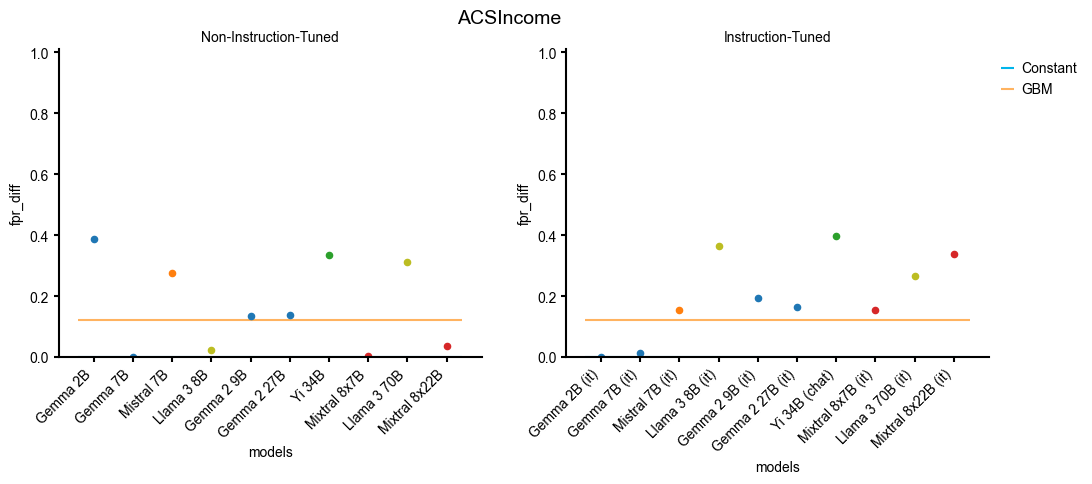

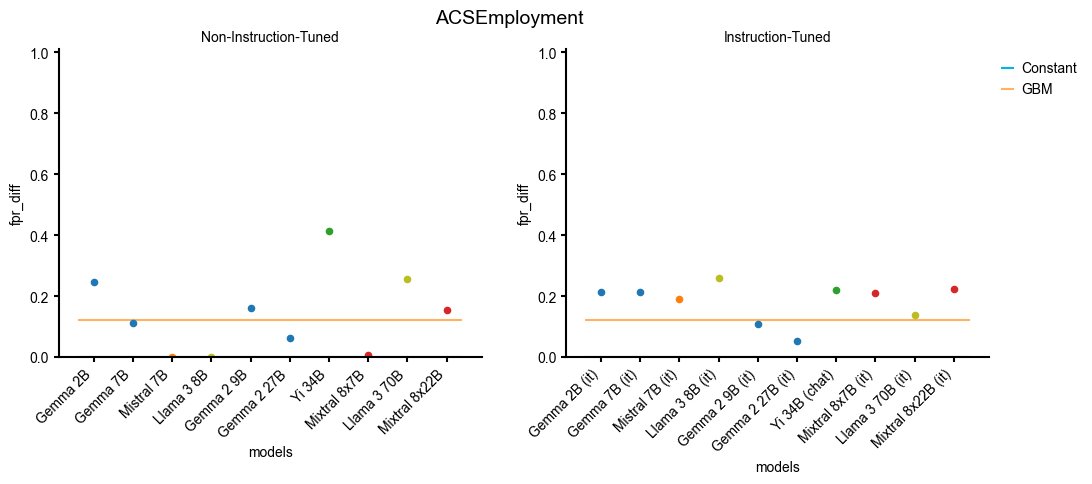

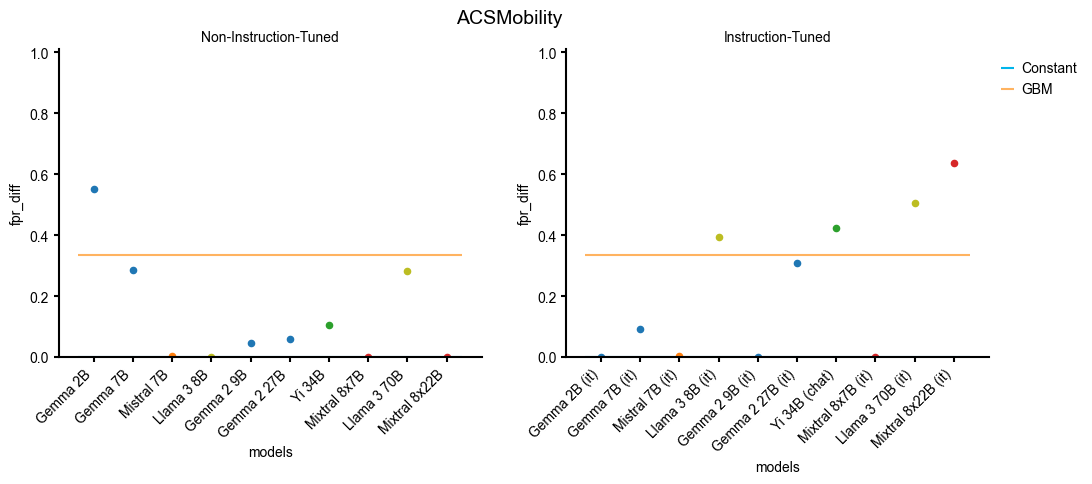

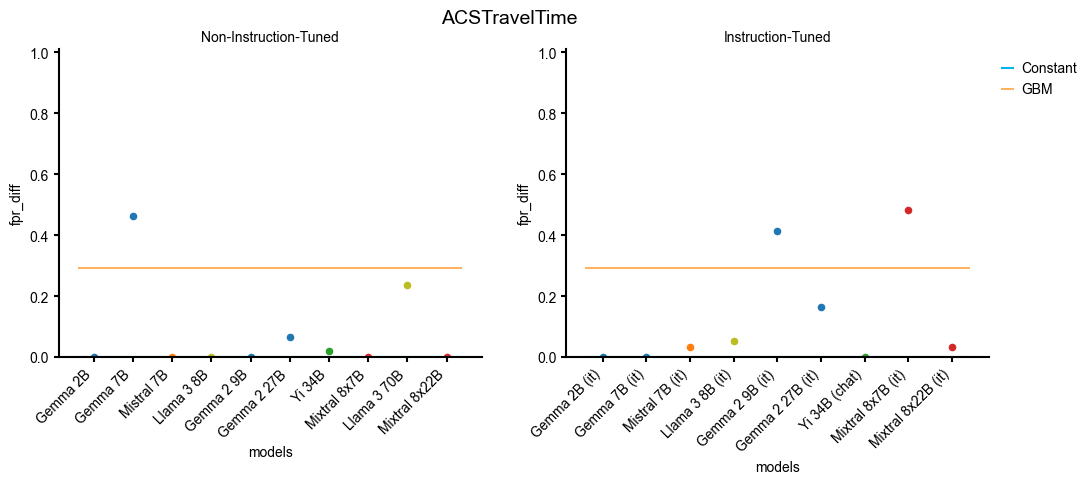

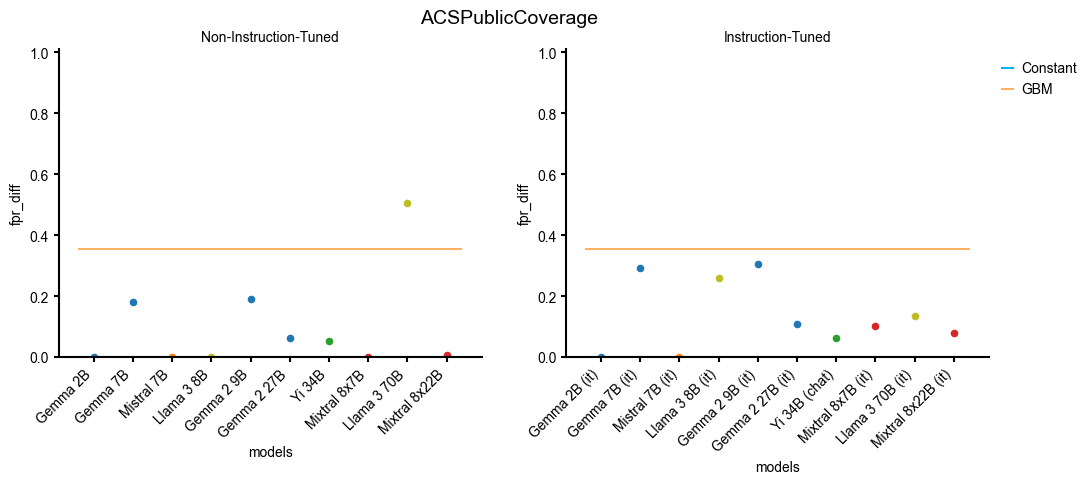

In [33]:
for task in ACS_TASKS:
    scatter_plot(task, metric="fpr_diff")

#### PPR

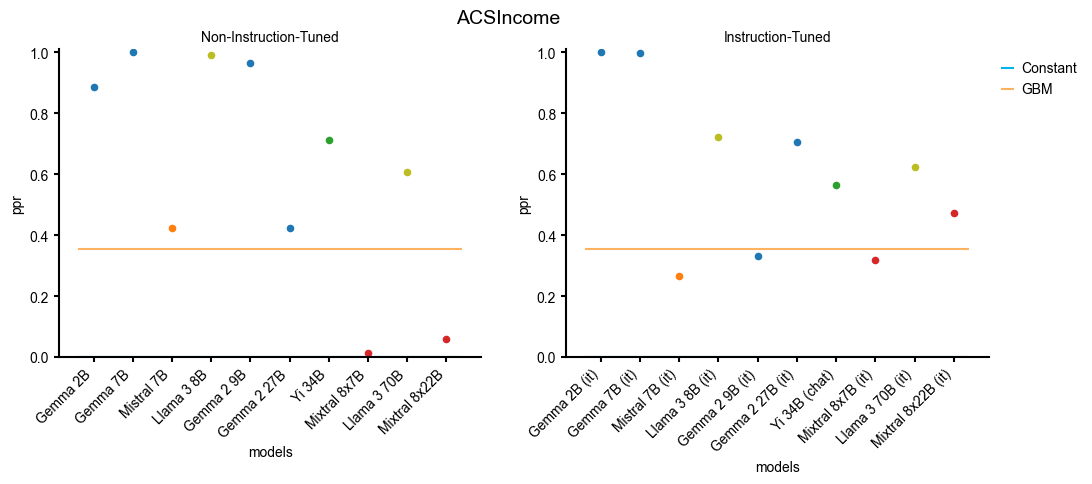

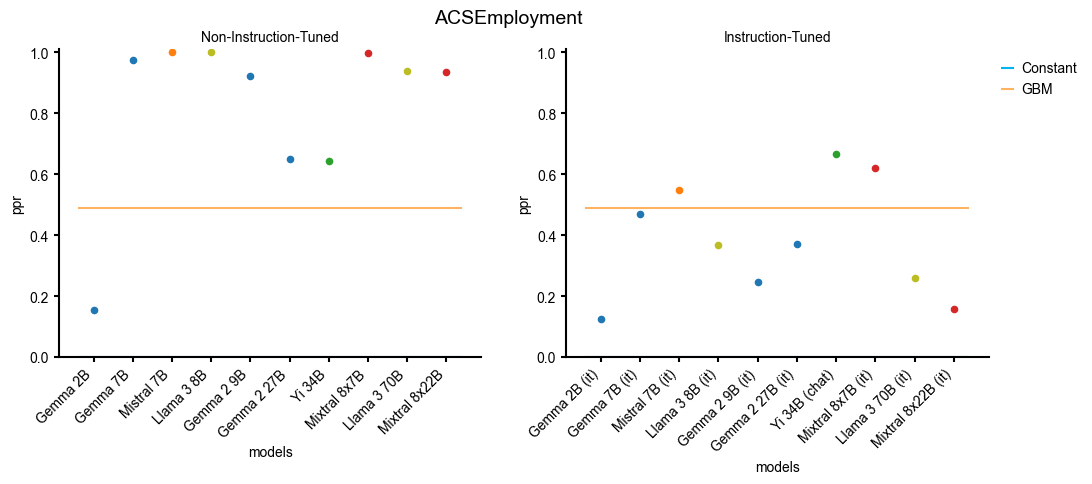

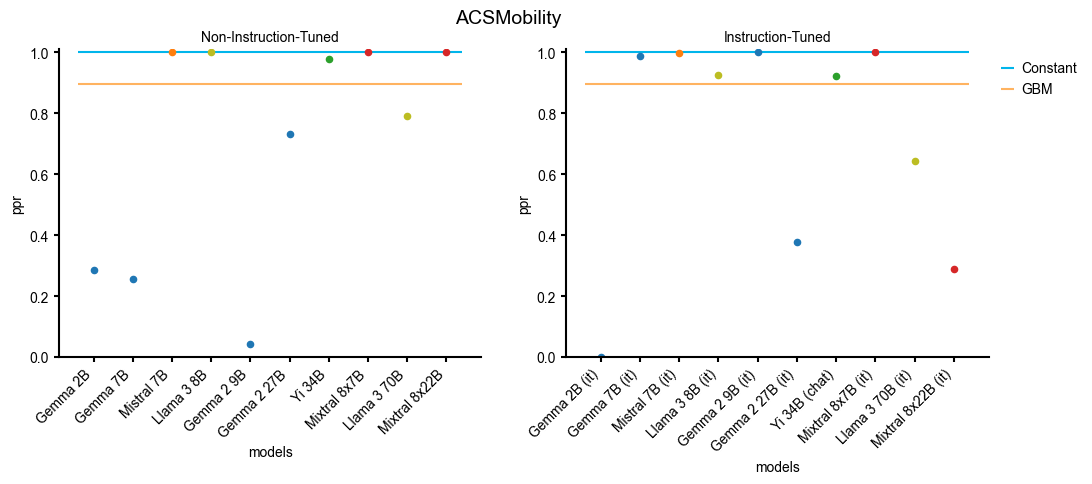

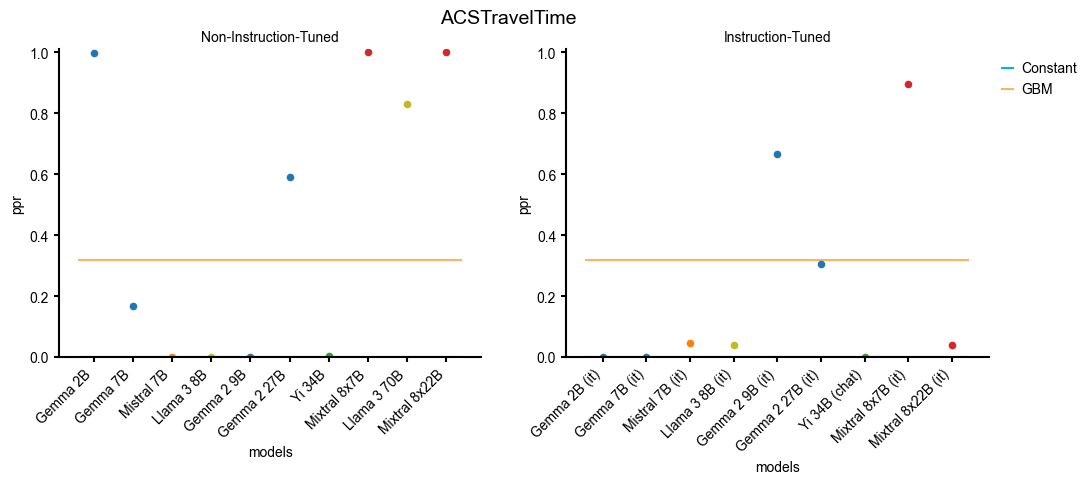

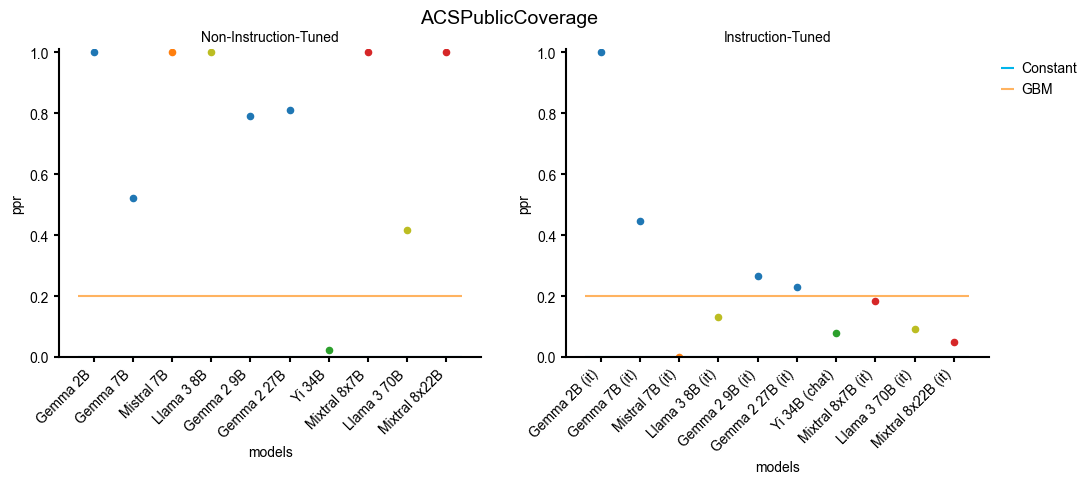

In [34]:
for task in ACS_TASKS:
    scatter_plot(task, metric="ppr")

## Towards Model Multiplicity

Can we find models with similar accuracy, but different error rates?

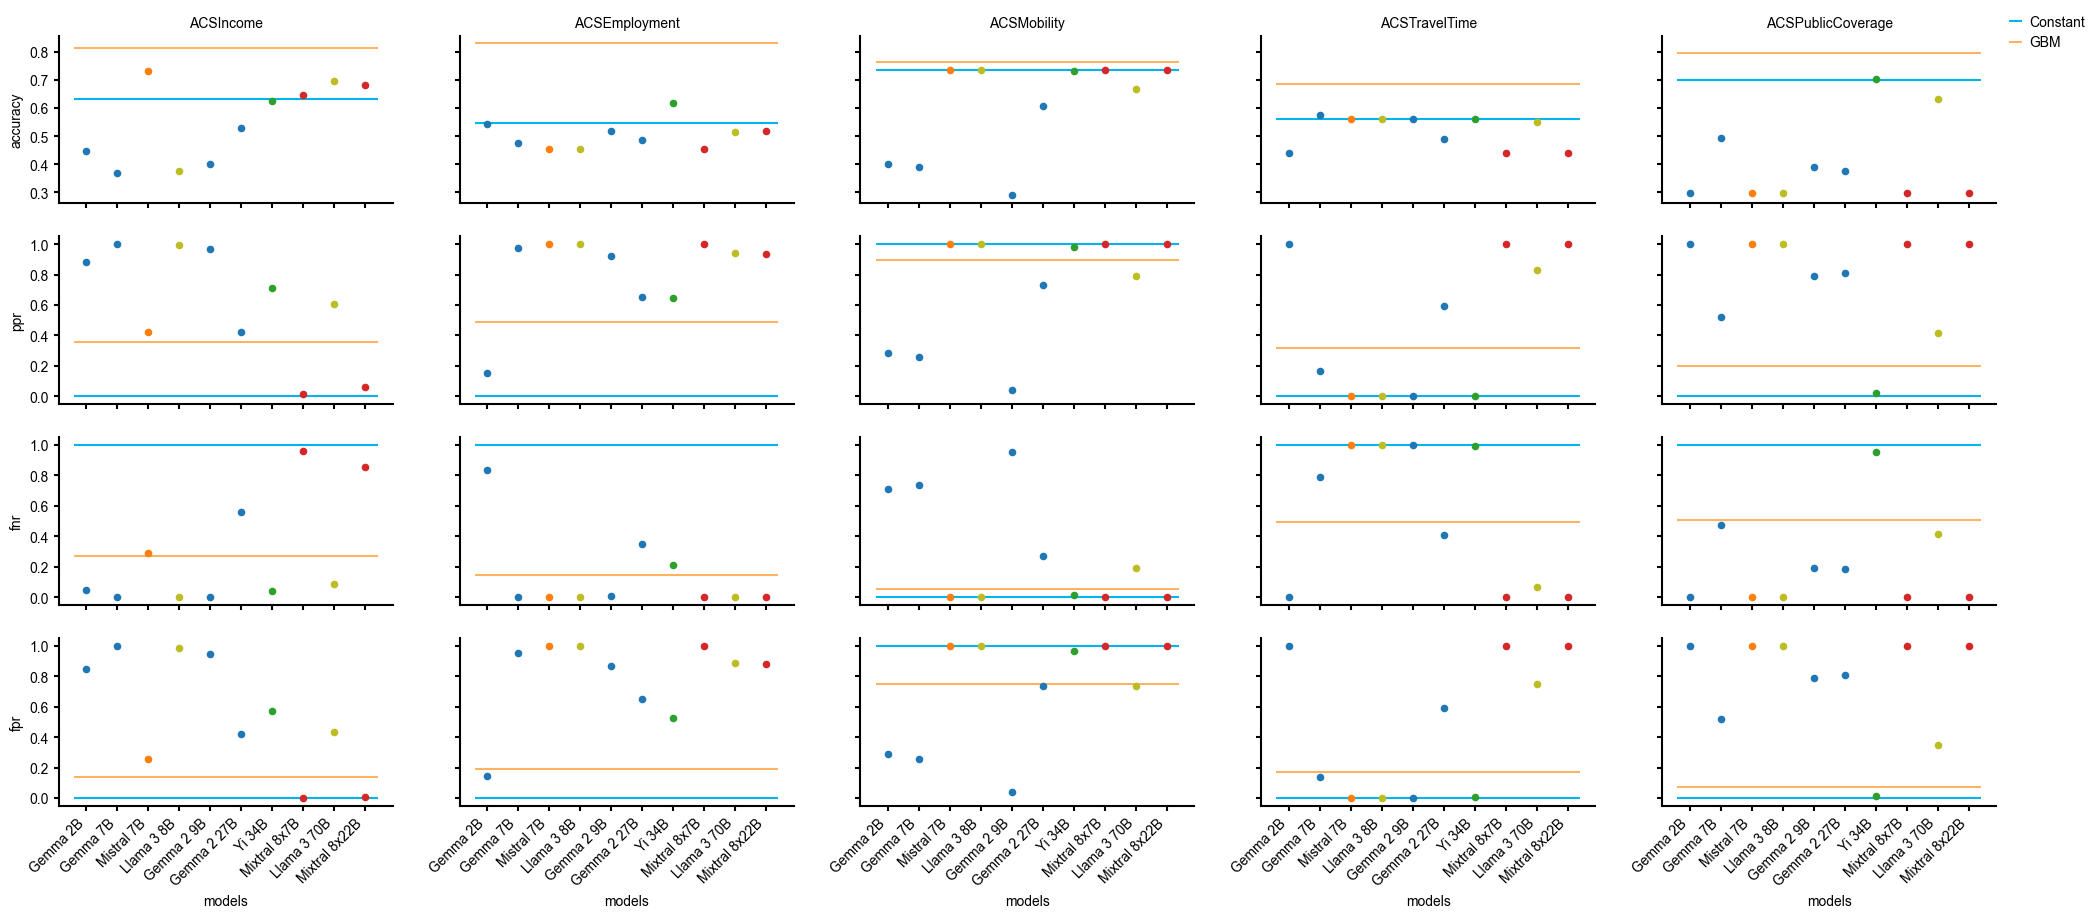

In [36]:
metrics = [
    "accuracy",
    # "accuracy_diff",
    "ppr",
    #"ppr_diff",
    "fnr",
    # "fnr_diff",
    "fpr",
    # "fpr_diff",
]
tasks = ACS_TASKS

models = get_models_for_task(task)
models_non_instruct = [m for m in models if not is_instruction_tuned(m)]
models_instruct = [m for m in models if is_instruction_tuned(m)]
models = models_non_instruct

fig, axs = plt.subplots(
    len(metrics),
    len(tasks),
    figsize=(5 * len(tasks), 2.5 * len(metrics)),
    sharex=True,
    sharey="row",
)

for j, t in enumerate(tasks):
    axs[0, j].set_title(t)
    axs[len(metrics) - 1, j].set_xlabel("models")
    for i, m in enumerate(metrics):
        axs[i, 0].set_ylabel(m)
        axs[i, j].set_xticks(
            torch.arange(0, len(models)),
            list(map(prettify_model_name, models)),
            rotation=45,
            ha="right",
        )

        offset = 0.4
        for baseline_name, baseline_res in baseline_results_all_tasks[t].items(): 
            if baseline_name in ["Constant", "GBM"]:
                axs[i,j].hlines(baseline_res[m], xmin=-offset, xmax=len(models)-(1-offset), colors=baseline_colors[baseline_name], label=baseline_name, linestyle='-', zorder=0)


        for model in models:
            try:

                results = results_all_tasks[t][model_to_key(model, t)]

                if len(results.keys())>1:
                    print(f"Multiple benchmark runs available, using first: {results_model.keys()[0]}")
                results = results[list(results.keys())[0]]
                
                # get correct index for model
                idx = (
                    models_non_instruct.index(model)
                    if not is_instruction_tuned(model)
                    else models_instruct.index(model)
                )

                axs[i, j].scatter(
                    idx,
                    results[m],
                    c=model_colors[model.split("/")[1].split("-")[0]],
                    s=20,
                )

                # axs[i, j].bar(
                #     idx,
                #     results_all_tasks[task][model_to_key(model, task)][m],
                #     width=0.25,
                #     color=model_colors[model.split("/")[1].split("-")[0]],
                # )
            except:
                print(
                    f"Results not availables for task '{t}' and model '{model}'. Skipped."
                )
legend_items = axs[0, -1].get_legend_handles_labels()
handles = legend_items[0]#+ legend_costs[0]
labels = legend_items[1] #+ legend_costs[1]

plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.0, 4.8), handlelength=0.95, handletextpad=0.5)

plt.show()

In [43]:
res_mixtral_8x22B = results_all_tasks["ACSIncome"][model_to_key("mistralai/Mixtral-8x22B-v0.1", "ACSIncome")]
res_mixtral_8x22B = res_mixtral_8x22B[list(res_mixtral_8x22B.keys())[0]]
res_llama_3_70b = results_all_tasks["ACSIncome"][model_to_key("meta-llama/Meta-Llama-3-70B", "ACSIncome")]
res_llama_3_70b = res_llama_3_70b[list(res_llama_3_70b.keys())[0]]

res_mixtral_8x22B["accuracy"], res_llama_3_70b["accuracy"]

(0.680967257434665, 0.6970982276960048)

In [42]:
res_llama_3_70b["fpr"], res_llama_3_70b["fpr"]

(0.4307003621087847, 0.4307003621087847)

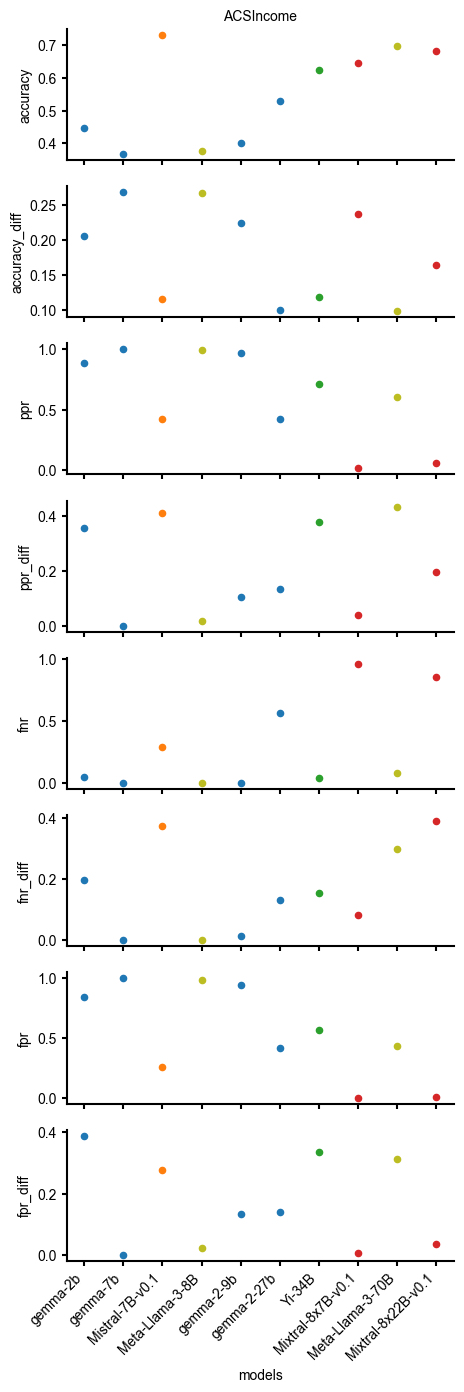

In [36]:
metrics = [
    "accuracy",
    "accuracy_diff",
    "ppr",
    "ppr_diff",
    "fnr",
    "fnr_diff",
    "fpr",
    "fpr_diff",
]
tasks = ["ACSIncome"]

models = get_models_for_task(task)
models_non_instruct = [m for m in models if not is_instruction_tuned(m)]
models_instruct = [m for m in models if is_instruction_tuned(m)]

fig, axs = plt.subplots(
    len(metrics),
    1,
    figsize=(5 * len(tasks), 2 * len(metrics)),
    sharex=True,
    sharey="row",
)

for j, t in enumerate(tasks):
    axs[0].set_title(t)
    axs[len(metrics) - 1].set_xlabel("models")
    for i, m in enumerate(metrics):
        axs[i].set_ylabel(m)
        axs[i].set_xticks(
            torch.arange(0, len(models_non_instruct)),
            list(map(model_name_only, models_non_instruct)),
            rotation=45,
            ha="right",
        )

        for model in models_non_instruct:
            try:

                results = results_all_tasks[t][model_to_key(model, t)]
                # get correct index for model
                idx = (
                    models_non_instruct.index(model)
                    if not is_instruction_tuned(model)
                    else models_instruct.index(model)
                )

                axs[i].scatter(
                    idx,
                    results[m],
                    c=model_colors[model.split("/")[1].split("-")[0]],
                    s=20,
                )

            except:
                print(
                    f"Results not availables for task '{t}' and model '{model}'. Skipped."
                )

plt.show()

## Agreement Rates

In [45]:
res_mixtral_8x22B = results_all_tasks["ACSIncome"][model_to_key("mistralai/Mixtral-8x22B-v0.1", "ACSIncome")]
res_mixtral_8x22B = res_mixtral_8x22B[list(res_mixtral_8x22B.keys())[0]]
res_llama_3_70b = results_all_tasks["ACSIncome"][model_to_key("meta-llama/Meta-Llama-3-70B", "ACSIncome")]
res_llama_3_70b = res_llama_3_70b[list(res_llama_3_70b.keys())[0]]

print(f"Accuracy\n Mixtral-8x22B:\t{res_mixtral_8x22B['accuracy']:0.4f}\n Llama-3-70B:\t{res_llama_3_70b['accuracy']:0.4f}")

Accuracy
 Mixtral-8x22B:	0.6810
 Llama-3-70B:	0.6971


In [79]:
mixtral_8x22b_scores = risk_scores_all_tasks['ACSIncome'][model_to_key('mistralai/Mixtral-8x22B-v0.1', 'ACSIncome')]
llama3_70b_scores = risk_scores_all_tasks['ACSIncome'][model_to_key('meta-llama/Meta-Llama-3-70B', 'ACSIncome')]



Agreement Rate

In [87]:
int(((mixtral_8x22b_scores > 0.5) == (llama3_70b_scores > 0.5)).sum())/len(mixtral_8x22b_scores)

0.5060498648242715

In [90]:
# Expected Agreement Rate (prob both are correct * prob both worng)
(mixtral_8x22b_acc * llama3_70b_acc) + (( 1- mixtral_8x22b_acc) *  (1 - llama3_70b_acc))

0.5713366514227582

## Test Space

In [ ]:
# available

available = [
    # Google Gemma2 models
    "google--gemma-2b",
    "google--gemma-1.1-2b-it",
    "google--gemma-7b",
    "google--gemma-1.1-7b-it",
    "google--gemma-2-9b",
    "google--gemma-2-9b-it",
    "google--gemma-2-27b",
    "google--gemma-2-27b-it",
    #
    # Meta Llama models
    # Llama 2
    # "models--meta-llama--Llama-2-7b-chat-hf",
    # "models--meta-llama--Llama-2-7b-hf",
    # Llama 3
    "meta-llama--Meta-Llama-3-8B",
    "meta-llama--Meta-Llama-3-8B-Instruct",
    "meta-llama--Meta-Llama-3-70B",
    "meta-llama--Meta-Llama-3-70B-Instruct",
    #
    # Llama 3.1 (there would also be 8B)
    # "Meta-Llama-3.1-70B",
    # "Meta-Llama-3.1-70B-Instruct",
    # "meta-llama--Meta-Llama-3.1-405B",
    # "models--meta-llama--Meta-Llama-3.1-405B",
    #
    # Yi models
    "01-ai--Yi-34B",
    "01-ai--Yi-34B-Chat",
    #
    # Qwen
    # "Qwen--Qwen1.5-72B",
    # "Qwen--Qwen1.5-72B-Chat",
    # Qwen 2
    "Qwen--Qwen2-1.5B",
    "Qwen--Qwen2-1.5B-Instruct",
    "Qwen--Qwen2-7B",
    "Qwen--Qwen2-7B-Instruct",
    "Qwen--Qwen2-72B",
    "Qwen--Qwen2-72B-Instruct",
    #
    # Mistral
    "mistralai--Mistral-7B-v0.1",
    "mistralai--Mistral-7B-Instruct-v0.2",
    "mistralai--Mixtral-8x7B-v0.1",
    "mistralai--Mixtral-8x7B-Instruct-v0.1",
    "mistralai--Mixtral-8x22B-v0.1",
    "mistralai--Mixtral-8x22B-Instruct-v0.1",
    #
    # Open AI
    # "openai-community--gpt2",
    # "openai-community--gpt2-large",
    # "openai-community--gpt2-xl",
    #
    # Other
    # "allenai--tulu-2-dpo-70b",
    # "hf-internal-testing--tiny-random-MistralForCausalLM",
    # "hf-internal-testing--tiny-random-gpt2",
]

In [ ]:
# LLMs to evaluate
LLM_MODELS = [
    # Google Gemma2 models
    "google/gemma-2b",
    "google/gemma-1.1-2b-it",
    "google/gemma-7b",
    "google/gemma-1.1-7b-it",
    "google/gemma-2-9b",
    "google/gemma-2-9b-it",
    "google/gemma-2-27b",
    "google/gemma-2-27b-it",
    # Meta Llama3 models
    "meta-llama/Meta-Llama-3-8B",
    "meta-llama/Meta-Llama-3-8B-Instruct",
    "meta-llama/Meta-Llama-3-70B",
    "meta-llama/Meta-Llama-3-70B-Instruct",
    # Mistral AI models
    "mistralai/Mistral-7B-v0.1",
    "mistralai/Mistral-7B-Instruct-v0.2",
    "mistralai/Mixtral-8x7B-v0.1",
    "mistralai/Mixtral-8x7B-Instruct-v0.1",
    "mistralai/Mixtral-8x22B-v0.1",
    "mistralai/Mixtral-8x22B-Instruct-v0.1",
    # Yi models
    "01-ai/Yi-34B",
    "01-ai/Yi-34B-Chat",
    # Qwen2 models
    # "Qwen/Qwen2-1.5B",
    # "Qwen/Qwen2-1.5B-Instruct",
    # "Qwen/Qwen2-7B",
    # "Qwen/Qwen2-7B-Instruct",
    # "Qwen/Qwen2-72B",
    # "Qwen/Qwen2-72B-Instruct",
]